# Model characteristics

- Same as the previous one, just with $\chi^2$ and fitted for one kinematic set

## Import all libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
import bkm10

## Load the view input data

- We're gonna focus just on set 1 for now
- This fits to model CFFs without error
- Comment 2 lines below "model dsig from KM15 CFFs" to fit to actual data

In [ ]:
filename = 'finalised pseudodata.csv'

sets = [1]

df = pd.read_csv(filename)

df = df[df['set'].isin(sets)]
df_cffs = pd.read_csv(filename, usecols=[0, 10, 12, 11, 18], skiprows=1,
                      names=['set', 'ReH', 'ReE', 'ReHt', 'DVCS'])
df_cffs = df_cffs[df_cffs['set'].isin(sets)]
df_cffs = df_cffs[['ReH', 'ReHt', 'ReE', 'DVCS']]

# only choose columns for which experimental data exists. 
# assign the differential cross section as a column vector

df_cffs = df_cffs[df.iloc[:, -2] > 0]
df = df.loc[df.iloc[:, -2] > 0]

df['phi'] = np.pi-np.deg2rad(df['phi'])

df_kins = df.iloc[:, 1:-2]

df_dsig_with_err = df.iloc[:, -2:]

# model dsig from KM15 CFFs

modelled_dsig = diff_cross(tf.convert_to_tensor(df_kins, dtype=tf.float32),
                        tf.convert_to_tensor(df_cffs, dtype=tf.float32))
df_dsig_with_err['dsig'] = modelled_dsig

# split data into training and validation

kins_train, kins_val, dsig_with_err_train, dsig_with_err_val = \
    train_test_split(df_kins, df_dsig_with_err, test_size=0.1, random_state=42)

# scale the relevant kinematics which will only be Q2, x, t {cols 1,2,3}
# add these scaled variables as separate columns: this will be useful later to pass in the raw kinematics into the physics layer

input_pipeline = make_pipeline(
    QuantileTransformer(output_distribution='uniform'),
    MinMaxScaler()
)

scaled_kins_train = input_pipeline.fit_transform(kins_train.to_numpy()[:, 1:4])
scaled_kins_val = input_pipeline.transform(kins_val.to_numpy()[:, 1:4])
kins_train = np.column_stack([kins_train, scaled_kins_train])
kins_val = np.column_stack([kins_val, scaled_kins_val])

# convert to tensors
dsig_train, err_train = dsig_with_err_train['dsig'].values.reshape(-1,1), dsig_with_err_train['err_dsig'].values.reshape(-1,1)
dsig_val, err_val = dsig_with_err_val['dsig'].values.reshape(-1,1), dsig_with_err_val['err_dsig'].values.reshape(-1,1)

kins_train = tf.convert_to_tensor(kins_train, dtype = tf.float32)
kins_val = tf.convert_to_tensor(kins_val, dtype = tf.float32)
dsig_train = tf.convert_to_tensor(dsig_train, dtype = tf.float32)
dsig_val = tf.convert_to_tensor(dsig_val, dtype = tf.float32)

/home/pratik/.venvs/code/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (14). n_quantiles is set to n_samples.
  warnings.warn(


## Create the model

In [ ]:
tf.random.set_seed(42)

def create_model(lr=1e-1):

    all_input_kins = keras.Input(shape=(8,))

    kins_raw = keras.layers.Lambda(lambda x: x[:, 0:5])(all_input_kins)
    Q2_x_t_scaled = keras.layers.Lambda(lambda x: x[:, 5:8])(all_input_kins)
    
    hidden = keras.layers.Dense(100, activation='relu')(Q2_x_t_scaled)
    hidden = keras.layers.Dense(50, activation='relu')(hidden)
    hidden = keras.layers.Dense(25, activation='relu')(hidden)
    hidden = keras.layers.Dense(10, activation='relu')(hidden)

    # predicted_cffs = keras.layers.Dense(4, name='predicted_cff_layer')(hidden)

    cff_1 = keras.layers.Dense(1, name='cff1')(hidden)
    cff_2 = keras.layers.Dense(1, name='cff2')(hidden)
    cff_3 = keras.layers.Dense(1, name='cff3')(hidden)
    cff_4 = keras.layers.Dense(1, name='cff4', activation='softplus')(hidden)
    predicted_cffs = keras.layers.Concatenate(name='predicted_cff_layer')(
        [cff_1, cff_2, cff_3, cff_4]
    )
    
    predicted_dsig = keras.layers.Lambda(
        lambda args: tf.math.log1p(diff_cross(args[0], args[1])),
        output_shape=(1,)
    )([kins_raw, predicted_cffs])
    
    model = keras.Model(inputs=all_input_kins, outputs=predicted_dsig)

    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mae')

    return model


modifyLR = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=30, min_lr=1e-5, mode='auto')

EarlyStop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=40, restore_best_weights=True)

model = create_model()

# The data is full of extremely small values with a few extremely large values
# MSE will prioritise fixing large dsig values while smaller errors will be washed out
# So we need to add a weight which gives more priority to smaller target values

history = model.fit(kins_train, tf.math.log1p(dsig_train), validation_data=(kins_val, dsig_val),
                      epochs=300, batch_size=2, callbacks=[modifyLR, EarlyStop])

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 381ms/step - loss: 0.0592 - val_loss: 4.3532 - learning_rate: 0.1000
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0145 - val_loss: 4.3625 - learning_rate: 0.1000
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0144 - val_loss: 4.3476 - learning_rate: 0.1000
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104 - val_loss: 4.3534 - learning_rate: 0.1000
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0079 - val_loss: 4.3544 - learning_rate: 0.1000
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 4.3513 - learning_rate: 0.1000
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 4.3510 - learning_rate: 0.1000
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0039 - val_loss: 4.3538 - learning_rate: 0.1000
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 4.3514 - learning_rate: 0.1000
Epoch 10/300
7/7 ━━━━━━━━━

## Plot the differential cross section 

Predicted CFFs: [0.42748675 0.44496208 0.42845362 0.42735854]
Model CFFs: [-3.20664  2.16321  2.39131  0.17871]


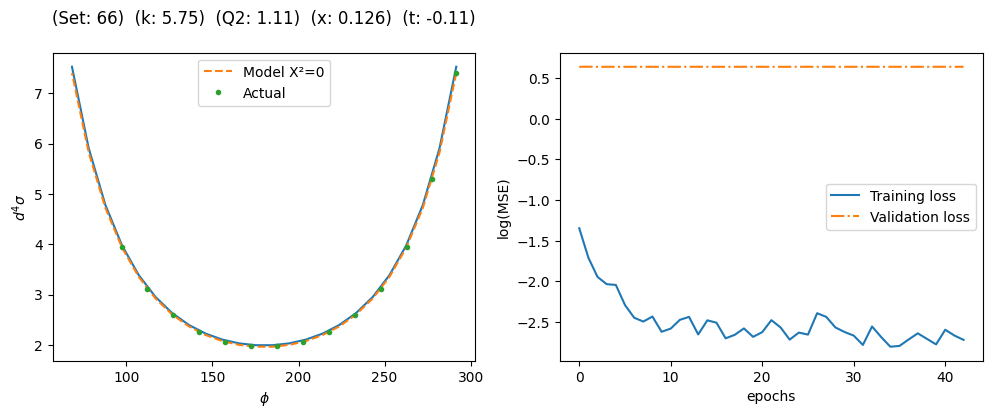

In [ ]:
N = 24

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[1].plot(np.log10(history.history['loss']), label='Training loss')
ax[1].plot(np.log10(history.history['val_loss']), '-.', label='Validation loss')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('log(MSE)')
ax[1].legend()

def graph(set_num=sets[0]):
    
    ax[0].clear()
    
    test_kins = df.loc[df['set'] == set_num, ['k', 'Q2', 'x', 't', 'phi']].values[0]
    test_kins = np.tile(test_kins, (N, 1))

    model_cffs = df_cffs.loc[df['set'] == set_num, ['ReH', 'ReHt', 'ReE', 'DVCS']].values[0]
    model_cffs = np.tile(model_cffs, (N, 1))
    
    phi_min = df.loc[df['set'] == set_num, 'phi'].values[-1]
    phi_max = df.loc[df['set'] == set_num, 'phi'].values[0]
    test_phi = np.linspace(phi_min, phi_max, N)

    test_kins[:, -1] = test_phi

    kins_test_scaled = input_pipeline.transform(test_kins[:,1:4])
    kins_test_input = np.column_stack([test_kins, kins_test_scaled])

    cff_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=model.get_layer('predicted_cff_layer').output
    )

    predicted_cffs = cff_model(tf.convert_to_tensor(kins_test_input), training=False).numpy()

    print('Predicted CFFs:', predicted_cffs[0])
    print('Model CFFs:', model_cffs[0])

    predicted_dsig = diff_cross(tf.convert_to_tensor(test_kins, dtype=tf.float32),
                                tf.convert_to_tensor(predicted_cffs, dtype=tf.float32))

    model_dsig = diff_cross(tf.convert_to_tensor(test_kins, dtype=tf.float32),
                            tf.convert_to_tensor(model_cffs, dtype=tf.float32))

    # Find the index in kins_train where the first three columns match kins[:, 1:4]
    match_idx = np.where(np.all(np.isclose(kins_train[:, 1:4].numpy(), test_kins[0, 1:4], atol=1e-8),axis=1))[0]

    act_phi = np.zeros(match_idx.size)
    act_dsig = np.zeros(match_idx.size)
    act_err = np.zeros(match_idx.size)
    for i in range(len(match_idx)):
        act_phi[i] = kins_train[match_idx[i], 4]
        act_dsig[i] = dsig_train[match_idx[i], 0 ]
        act_err[i] = err_train[match_idx[i], 0]

    act_phi = np.rad2deg(np.pi-act_phi)
    # act_phi = np.rad2deg(np.pi-df['phi'])
    test_phi = np.rad2deg(np.pi-test_phi)

    chi2_predicted = np.round(sum(
        ((model_dsig-predicted_dsig.numpy())**2)/(df['err_dsig'].to_numpy()**2)),3)

    ax[0].plot(test_phi, predicted_dsig, label=f'Predicted X²={chi2_predicted}')
    ax[0].plot(test_phi, model_dsig, '--', label=f'Model X²=0')
    ax[0].plot(act_phi, act_dsig, '.', label='Actual')
    # ax[0].errorbar(act_phi, df['dsig'], yerr=df['err_dsig'], fmt='.', label='Actual')
    ax[0].set_title(
        f'(Set: {set_num})  (k: {test_kins[0, 0]})  (Q2: {test_kins[0, 1]})  (x: {test_kins[0, 2]})  (t: {test_kins[0, 3]})\n')
    ax[0].set_xlabel(r'$\phi$')
    ax[0].set_ylabel(r'$d^{4}\sigma$')
    ax[0].legend()

graph()